# BERT, explain yourself! 📖

It has been over two years since transformer models took the NLP throne 🏅, but up until recently they couldn't tell you how they got to their prediction. Not anymore!

```python
>>> BERT('After many years of training I finally succeeded in achieving '
         'my black belt in machine learning. The road was very rough but '
         'I could not be more happy with the result!')
Sentiment: 99% Positive

>>> BERT, explain yourself!
As you wish:
```

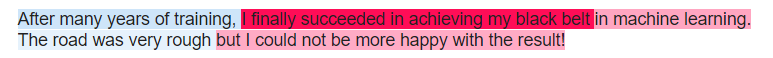

As you might have guessed from the colors, BERT has learned to harness the power of [SHAP](https://shap.readthedocs.io/en/latest/index.html)! SHAP is a game theoretic approach to explain the output of any machine learning model. Darker shades of pink indicate a positive contribution and the shades of blue indicate a negative contribution to the sentiment. This enables us to get an understanding of what goes on under the hood and not take predictions at their face value.

Let's dive 🤿 in and learn how you supercharge your NLP projects with explanations.

---

### 📚 Libraries!

In [1]:
!pip install --quiet shap==0.39
!pip install --quiet transformers==4.5.0

import shap
import transformers

from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TextClassificationPipeline)

     |████████████████████████████████| 358kB 18.8MB/s 
     |████████████████████████████████| 2.2MB 19.0MB/s 
     |████████████████████████████████| 3.3MB 57.0MB/s 
     |████████████████████████████████| 901kB 49.5MB/s 


## SHAP ❤️ 🤗 Transformers

Luckily for us, SHAP integrates well with our favourtie NLP library: 🤗 Transformers. It is as simple as selecting a (multiclass) classification objective (sentiment analysis in our case) and load the pre-trained tokenizer and model to combine them into a pipeline.

In [3]:
tokenizer_name = "distilbert-base-uncased"
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

tokenizer = transformers.DistilBertTokenizerFast.from_pretrained(tokenizer_name)
model = transformers.DistilBertForSequenceClassification.from_pretrained(model_name).cpu()

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

Let's first create a simple helper functions that for a piece of text will return the prediction and the explanation.

In [4]:
def score_and_visualize(text):
  prediction = pipe([text])
  print(prediction[0])

  explainer = shap.Explainer(pipe)
  shap_values = explainer([text])

  shap.plots.text(shap_values)

Now we can use it to analyse the sentiment of our intro example. In the visualization you can click on the predicted class, `POSITIVE` in this case, to receive an attribution color per sub-sentence. Clicking on these sub-sentences reveals the actual scores.

In [5]:
score_and_visualize('After many years of training, I finally succeeded in achieving '
                    'my black belt in machine learning. The road was very rough but '
                    'I could not be more happy with the result!')

[{'label': 'NEGATIVE', 'score': 0.0052384971641004086}, {'label': 'POSITIVE', 'score': 0.9947615265846252}]


,,"After many years of training,",I finally succeeded in achieving my black belt,in machine learning.,The road was very rough,but I could not be more happy with the result!,
NEGATIVE,0.0,0.829,-4.074,-0.944,0.469,-1.328,0.0
POSITIVE,-0.0,-0.829,4.074,0.944,-0.469,1.328,-0.0


Qualitatively the result makes sense: "After many years of training," and "The road was very rough" contribute towards a negative sentiment while the rest of the sentence contibrutes positively.

Looking at the numbers in more detail 🔍: 

> The first section: "After many years of training,"
  contains 6 tokens contributing -0.829 to the log odds of a positive prediction. Summing over all log odds results in a total of ~5 which translates into the 99% probability that we saw above.

Now that we know how to use it let's check it out on a few specific cases:
- Word sensitivity analysis 
- Granular attribution for a long piece of text




## Word sensitivity

Let's see how the model fares given the relatively neutral wording: `'I am neutral to the movie.'`

In [6]:
score_and_visualize('I am neutral to the movie.')

[{'label': 'NEGATIVE', 'score': 0.9993385672569275}, {'label': 'POSITIVE', 'score': 0.0006614179001189768}]


,,I am,neutral,to,the movie,.,
NEGATIVE,-0.0,0.13,5.8,0.534,-0.928,0.822,-0.0
POSITIVE,0.0,-0.13,-5.8,-0.534,0.928,-0.822,0.0


A negative sentiment, heavily attributed to the word `neutral`. Let's change that up and replace it with `impartial`.

In [7]:
score_and_visualize('I am impartial to the movie.')

[{'label': 'NEGATIVE', 'score': 0.0006303603295236826}, {'label': 'POSITIVE', 'score': 0.9993696212768555}]


,,I am,impart,ial,to the movie.,
NEGATIVE,-0.0,-1.346,-4.92,-0.499,-1.514,-0.0
POSITIVE,0.0,1.346,4.92,0.499,1.514,-0.0


The sentiment flips over 🙃 completely! Once again attributing most of the sentiment to the sub-word `impart`. This demonstrates how we can analyse the sentivity of a model in a targeted way using SHAP values.

## 🎬 Performance on a larger piece of text 
Let's see how it fares on a larger piece of text that we could encounter during an acutal use-case. Here, we have taken a review from the well known IMDB movie review dataset.

In [8]:
imdb_review = ('This is easily the most underrated film in the Brooks cannon. '
               'Sure, its flawed. It does not give a realistic view of '
               'homelessness (unlike, say, how Citizen Kane gave a realistic '
               'view of lounge singers, or Titanic gave a realistic view of '
               'Italians YOU IDIOTS). Many of the jokes fall flat. But still, '
               'this film is very lovable in a way many comedies are not, and '
               'to pull that off in a story about some of the most traditionally '
               'reviled members of society is truly impressive. Its not The '
               'Fisher King, but its not crap, either. My only complaint is that '
               'Brooks should have cast someone else in the lead (I love Mel as '
               'a Director and Writer, not so much as a lead).')

score_and_visualize(imdb_review)

[{'label': 'NEGATIVE', 'score': 0.0020249534863978624}, {'label': 'POSITIVE', 'score': 0.9979750514030457}]


,,"This is easily the most underrated film in the Brooks cannon. Sure, its flawed. It does not give a realistic view of homelessness (unlike, say, how Citizen Kane gave a realistic view of lounge singers, or Titanic gave a realistic view of Italians YOU IDIOTS)",". Many of the jokes fall flat. But still, this film is very lovable in a way many comedies are not,","and to pull that off in a story about some of the most traditionally reviled members of society is truly impressive. Its not The Fisher King, but its not crap, either.","My only complaint is that Brooks should have cast someone else in the lead (I love Mel as a Director and Writer, not so much as a lead).",
NEGATIVE,-0.0,1.43,-3.993,-5.115,1.15,-0.0
POSITIVE,0.0,-1.43,3.993,5.115,-1.15,0.0


The results look promising! The first and final section being correctly identified as contributing towards negative sentiment, while the middle section has positive tone.

Not only does this give a more granular and insightfull prediction result, it also allows us a look into what the model is able to capture.

## 🔬 Try it yourself!

Now that you have some inspiration 🌈, be sure to try it out using the text widget below.

In [10]:
#@markdown ---
your_movie_review = 'This movie is great!' #@param {type:"string"}

score_and_visualize(your_movie_review)
#@markdown ---

[{'label': 'NEGATIVE', 'score': 0.00012397165119182318}, {'label': 'POSITIVE', 'score': 0.9998760223388672}]


,,This movie,is,great,!,
NEGATIVE,0.0,-2.227,-1.095,-5.052,-1.304,0.0
POSITIVE,-0.0,2.227,1.095,5.052,1.304,-0.0


# 🏁 Takeaways
You made it to the finish! As we have seen, SHAP is ready to be used in your favorite 🤗 Transformers pipeline. Furthermore, the results look great in a qualitative sense, and provide extra insight into model predictions. Make sure to try it out in your next NLP project and take it to the next level!

Tip: when inference time if of high priority, we advice that you evaluate the model on the GPU 🔥. This can result in a double digit increase incrase in performance ⚡ (~40x in the example). In the appendix we added a comparison.

# Appendix
- Implementation that runs on GPU (~40x faster! ⚡)
- Visualization of a single prediction using the SHAP force plot
- How does the model fare under double negations

## Implementation that runs on the GPU 🔥 

For an actual usecase you might want to run the model evaluations on the gpu. Here we show how that is done.

In [11]:

!pip install --quiet shap==0.39
!pip install --quiet transformers==4.5.0
!pip install --quiet torch==1.8.1+cu101
!pip install --quiet nlp==0.4.0

import nlp
import shap
import transformers
import torch
import numpy as np

     |████████████████████████████████| 1.7MB 22.2MB/s 
     |████████████████████████████████| 245kB 53.2MB/s 


In [12]:
tokenizer_name = "distilbert-base-uncased"
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

tokenizer = transformers.DistilBertTokenizerFast.from_pretrained(tokenizer_name)
model_cpu = transformers.DistilBertForSequenceClassification.from_pretrained(model_name).cpu()
model_gpu = transformers.DistilBertForSequenceClassification.from_pretrained(model_name).cuda()
labels = [x[0] for x in sorted(model.config.label2id.items(), key=lambda x: x[1])]

def model_prediction_cpu(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', 
                                        max_length=512, truncation=True) for v in x]).cpu()
    attention_mask = (tv!=0).type(torch.int64).cpu()
    outputs = model_cpu(tv, attention_mask=attention_mask)[0]
    scores = torch.nn.Softmax(dim=-1)(outputs)
    val = torch.logit(scores).detach().numpy()

    return val

def model_prediction_gpu(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', 
                                        max_length=512, truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model_gpu(tv, attention_mask=attention_mask)[0]
    scores = torch.nn.Softmax(dim=-1)(outputs)
    val = torch.logit(scores).detach().cpu().numpy()

    return val

cpu_explainer = shap.Explainer(model_prediction_cpu, tokenizer, output_names=labels)    
gpu_explainer = shap.Explainer(model_prediction_gpu, tokenizer, output_names=labels)

shap_values = gpu_explainer(
    ['After many years of training, I finally succeeded in achieving '
     'my black belt in machine learning. The road was very rough but '
     'I could not be more happy with the result!']
)

output = shap.plots.text(shap_values)

,,"After many years of training,",I finally succeeded in achieving my black belt,in machine learning.,The road was very rough,but I could not be more happy with the result!,
NEGATIVE,-0.0,0.829,-4.074,-0.944,0.469,-1.328,0.0
POSITIVE,0.0,-0.829,4.074,0.944,-0.469,1.328,0.0


### A note on performance


In [13]:
benchmark_dataset = nlp.load_dataset("imdb")["train"][:1]

print(f'# characters: {len(benchmark_dataset["text"][0])}')

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/76cdbd7249ea3548c928bbf304258dab44d09cd3638d9da8d42480d1d1be3743. Subsequent calls will reuse this data.
# characters: 806


In [14]:
!nvidia-smi

Fri Apr 23 10:32:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    29W /  70W |   3398MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
%%timeit -n1 -r1
gpu_explainer(benchmark_dataset)

1 loop, best of 1: 1.06 s per loop


In [16]:
%%timeit -n1 -r1
cpu_explainer(benchmark_dataset)

Partition explainer: 100%|██████████| 2/2 [00:37<00:00, 18.56s/it]

1 loop, best of 1: 37.1 s per loop


## SHAP Force 💪 plot of a given class

If you want to investigate a single instance and class prediciton you can revert to the SHAP force plot.

In [17]:
shap.plots.text(shap_values[0,:,"POSITIVE"])

## Double negations 🚫🚫 = ➕? 

To challenge the model, let's try a double negation and it's variations:

In [18]:
ds = ['I do not dislike ...',
      'I do dislike ...',
      'I do like ...']

_ = list(map(score_and_visualize, ds))

[{'label': 'NEGATIVE', 'score': 0.02863878384232521}, {'label': 'POSITIVE', 'score': 0.9713612198829651}]


,,I do,not,dislike,.,..,
NEGATIVE,0.0,-1.18,-1.043,-0.775,-1.334,-0.154,0.0
POSITIVE,-0.0,1.18,1.043,0.775,1.334,0.154,-0.0


[{'label': 'NEGATIVE', 'score': 0.9975295662879944}, {'label': 'POSITIVE', 'score': 0.002470403676852584}]


,,I do,dislike,.,.,.,
NEGATIVE,-0.0,0.74,2.93,0.016,0.915,0.595,-0.0
POSITIVE,0.0,-0.74,-2.93,-0.016,-0.915,-0.595,0.0


[{'label': 'NEGATIVE', 'score': 0.0003826273023150861}, {'label': 'POSITIVE', 'score': 0.9996173977851868}]


,,I do,like,.,..,
NEGATIVE,-0.0,-5.495,-3.261,-0.535,0.618,-0.0
POSITIVE,0.0,5.495,3.261,0.535,-0.618,0.0


The model is able to capture the double negations. Hence, no suprises here.